# Système de recommandation de livres basé sur le contenu

# Cahier des charges

Projet : Système de recommandation de livres

Objectif : 
- Prédire les livres qu'un utilisateur pourrait aimer en fonction de ses préférences (recommandation collaborative) et des similarités avec d'autres livres (recommandation basée sur le contenu)

Techniques Utilisées :
- Filtrage collaboratif (basé-mémoire/basé-modèle)
- Recommandation basée sur le contenu (TF-IDF, embeddings : Word2Vec, GloVe, etc)
- Modèles : KNN, SVD, NMF, etc

Étapes :

Dataset
- Utiliser : https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
- Tester d’autres datasets de recommandation de livres

Prétraitement
- Nettoyage des données (valeurs manquantes, doublons)
- Feature engineering (genres, auteurs, notes moyennes)
- Vectorisation des textes (titres, descriptions) avec TF-IDF, Word2Vec, GloVe, etc

In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD

In [2]:
path = "./datasets/"

books = pd.read_csv(path+"Books.csv")
users= pd.read_csv(path+"Users.csv")
ratings = pd.read_csv(path+"Ratings.csv")

In [3]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [4]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [5]:
users.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

## Préparation des données

In [6]:
books.rename(columns={'Book-Title':'title', 'Book-Author': 'author','Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
books.head(10)

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


In [7]:
ratings.rename(columns={'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)
ratings.head(10)

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [8]:
nb_ratings=ratings['user_id'].value_counts() > 100
nb_ratings

user_id
11676      True
198711     True
153662     True
98391      True
35859      True
          ...  
116180    False
116166    False
116154    False
116137    False
276723    False
Name: count, Length: 105283, dtype: bool

In [9]:
nb_ratings[nb_ratings].shape

(1825,)

In [10]:
nb_users=nb_ratings[nb_ratings].index
nb_users

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       238186,  99441, 187410, 262070,  70183,  40553,  39345, 266283, 189666,
       140879],
      dtype='int64', name='user_id', length=1825)

In [11]:
ratings_filtered=ratings[ratings['user_id'].isin(nb_users)]
ratings_filtered

,user_id,ISBN,rating
412,276925,0006511929,0
413,276925,002542730X,10
414,276925,0060520507,0
415,276925,0060930934,0
416,276925,0060951303,0
...,...,...,...
1149633,276680,1884910033,0
1149634,276680,1888173408,7
1149635,276680,1888173564,8
1149636,276680,1888173572,0


In [12]:
users.rename(columns={'User-ID':'user_id', 'Location':'location','Age':'age'}, inplace=True)
users.head(10)

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [13]:
def show_image(url, width=100):
    """ Affiche les images du dataset"""
    return f'<img src="{url}" width="{width}">'

def url_to_img(df, func):
    return df.style.format({'Image-URL-S':func, 'Image-URL-M':func, 'Image-URL-L':func}, escape=False)

In [14]:
books.isnull().sum()

ISBN         0
title        0
author       2
year         0
publisher    2
dtype: int64

In [15]:
books.dropna(inplace=True)
books.isnull().sum()

ISBN         0
title        0
author       0
year         0
publisher    0
dtype: int64

In [16]:
books.shape

(271356, 5)

lignes a verif :

- 118033
- 128890
- 129037
- 187689
- 209540
- 220731
- 221678

In [17]:
books.duplicated().sum()

0

In [18]:
ratings.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

In [19]:
ratings.duplicated().sum()

0

In [20]:
ratings['user_id'].value_counts()

user_id
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [21]:
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [22]:
users.shape

(278858, 3)

## Feature engineering 

- Ajout de la note moyenne de chaque livre
- Ajout de la note moyenne de l'utilisateur 
- Ajout du nombre de notes de chaque livre
- Fusion des datasets pour en avoir un basé sur les utilisateurs avec leurs notes moyennes et celles des livres

In [23]:
book_rating = ratings.groupby('ISBN')['rating'].mean().reset_index()
book_rating.head()

,ISBN,rating
0,0330299891,3.0
1,0375404120,1.5
2,0586045007,0.0
3,9022906116,3.5
4,9032803328,0.0


In [24]:
rating_books=ratings.merge(books, on='ISBN')

rating_books

,user_id,ISBN,rating,title,author,year,publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
1031127,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig
1031128,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1031129,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1031130,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books


In [25]:
num_ratings=rating_books.groupby('title')['rating'].count().reset_index()
num_ratings.rename(columns={'rating':'num_ratings'}, inplace=True)

num_ratings

,title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241063,Ã?Â?lpiraten.,2
241064,Ã?Â?rger mit Produkt X. Roman.,4
241065,Ã?Â?sterlich leben.,1
241066,Ã?Â?stlich der Berge.,3


In [26]:
books_avg_ratings=book_rating.merge(books, on='ISBN')
books_avg_ratings=books_avg_ratings.merge(num_ratings, on='title')
books_avg_ratings.rename(columns={'rating':'book_avg_rating'}, inplace=True)
books_avg_ratings.head()

,ISBN,book_avg_rating,title,author,year,publisher,num_ratings
0,0000913154,8.0,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,1
1,0001010565,0.0,Mog's Christmas,Judith Kerr,1992,Collins,2
2,0001046438,9.0,Liar,Stephen Fry,0,Harpercollins Uk,14
3,0001046713,0.0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,1
4,000104687X,6.0,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers,1


In [27]:
books_avg_ratings.shape

(270147, 7)

In [28]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [29]:
user_stats = ratings.groupby('user_id')['rating'].mean().reset_index()
user_stats.columns = ['user_id', 'user_avg_rating']

user_stats


,user_id,user_avg_rating
0,2,0.000000
1,7,0.000000
2,8,2.166667
3,9,2.000000
4,10,3.000000
...,...,...
105278,278846,4.000000
105279,278849,2.250000
105280,278851,3.956522
105281,278852,8.000000


In [30]:
users_avg_rating=users.merge(user_stats, on='user_id')

users_avg_rating

,user_id,location,age,user_avg_rating
0,2,"stockton, california, usa",18.0,0.000000
1,7,"washington, dc, usa",NaN,0.000000
2,8,"timmins, ontario, canada",NaN,2.166667
3,9,"germantown, tennessee, usa",NaN,2.000000
4,10,"albacete, wisconsin, spain",26.0,3.000000
...,...,...,...,...
105278,278846,"toronto, ontario, canada",23.0,4.000000
105279,278849,"georgetown, ontario, canada",23.0,2.250000
105280,278851,"dallas, texas, usa",33.0,3.956522
105281,278852,"brisbane, queensland, australia",32.0,8.000000


In [31]:
df_avg=ratings.merge(users_avg_rating, on='user_id')
df_avg

,user_id,ISBN,rating,location,age,user_avg_rating
0,276725,034545104X,0,"tyler, texas, usa",NaN,0.000000
1,276726,0155061224,5,"seattle, washington, usa",NaN,5.000000
2,276727,0446520802,0,"h, new south wales, australia",16.0,0.000000
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,4.500000
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,4.500000
...,...,...,...,...,...,...
1149775,276704,1563526298,9,"cedar park, texas, usa",NaN,1.882353
1149776,276706,0679447156,0,"quebec, quebec, canada",18.0,0.000000
1149777,276709,0515107662,10,"mannington, west virginia, usa",38.0,10.000000
1149778,276721,0590442449,10,"providence, rhode island, usa",14.0,10.000000


In [32]:
df_final=df_avg.merge(books_avg_ratings, on='ISBN')

df_final.head()

,user_id,ISBN,rating,location,age,user_avg_rating,book_avg_rating,title,author,year,publisher,num_ratings
0,276725,034545104X,0,"tyler, texas, usa",NaN,0.0,2.933333,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
1,276726,0155061224,5,"seattle, washington, usa",NaN,5.0,2.500000,Rites of Passage,Judith Rae,2001,Heinle,14
2,276727,0446520802,0,"h, new south wales, australia",16.0,0.0,4.060345,The Notebook,Nicholas Sparks,1996,Warner Books,650
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,4.5,3.000000,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,1
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,4.5,6.000000,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,1


In [33]:
df_final.shape

(1031132, 12)

## Vectorisation des textes (TF-IDF, W2V, GloVe)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [37]:
def nettoyage_texte(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    return text

df_final['title'] = df_final['title'].apply(nettoyage_texte)
df_final['author'] = df_final['author'].apply(nettoyage_texte)
df_final['publisher'] = df_final['publisher'].apply(nettoyage_texte)


In [38]:
df_final.head()

,user_id,ISBN,rating,location,age,user_avg_rating,book_avg_rating,title,author,year,publisher,num_ratings
0,276725,034545104X,0,"tyler, texas, usa",NaN,0.0,2.933333,flesh tones a novel,m j rose,2002,ballantine books,60
1,276726,0155061224,5,"seattle, washington, usa",NaN,5.0,2.500000,rites of passage,judith rae,2001,heinle,14
2,276727,0446520802,0,"h, new south wales, australia",16.0,0.0,4.060345,the notebook,nicholas sparks,1996,warner books,650
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,4.5,3.000000,help level 1,philip prowse,1999,cambridge university press,1
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,4.5,6.000000,the amsterdam connection level 4 cambridge en...,sue leather,2001,cambridge university press,1


In [ ]:
tfidf=TfidfVectorizer(max_features=5000)
title_matrix=tfidf.fit_transform(df_final['title'])

In [52]:
title_matrix.shape

(1031132, 5000)

In [53]:
tfidf.get_feature_names_out()[:20]

array(['01', '02', '03', '10', '100', '1000', '1001', '101', '10th', '11',
       '12', '13', '14', '15', '150', '16', '17', '18', '19', '1984'],
      dtype=object)

In [55]:
import gensim

In [56]:
titles=df_final.title.apply(gensim.utils.simple_preprocess)

titles

0                                      [flesh, tones, novel]
1                                       [rites, of, passage]
2                                            [the, notebook]
3                                              [help, level]
4          [the, amsterdam, connection, level, cambridge,...
                                 ...                        
1031127    [edgar, cayce, on, the, akashic, records, the,...
1031128    [get, clark, smart, the, ultimate, guide, for,...
1031129    [eight, weeks, to, optimum, health, proven, pr...
1031130    [the, sherbrooke, bride, bride, trilogy, paper...
1031131                                [fourth, grade, rats]
Name: title, Length: 1031132, dtype: object

In [57]:
w2v=gensim.models.Word2Vec(sentences=titles, vector_size=100, window=5, workers=4, min_count=5)

In [59]:
w2v.train(titles, epochs=100, total_examples=len(titles))

(423161333, 521150200)

In [62]:
def get_title_vector(tokens):
    vectors = [w2v.wv[word] for word in tokens if word in w2v.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v.vector_size)

In [63]:
titles_tokens=titles.apply(get_title_vector)

titles_tokens

0          [-0.783094, -1.1938396, -0.37176642, -0.121578...
1          [-0.08311454, 0.117842555, -1.1111966, -0.5351...
2          [0.95981073, 0.15465441, -0.2339472, 0.3857110...
3          [-0.6792951, -1.6305785, -0.45948434, -4.81681...
4          [0.6477012, -0.57604474, -2.1124094, -1.383546...
                                 ...                        
1031127    [0.06502874, 0.47802743, -0.050580375, -0.1294...
1031128    [-0.7679844, 0.3170536, -0.4213172, 0.93032885...
1031129    [-3.0298285, -0.6434664, -0.89390486, -1.04339...
1031130    [2.211787, -0.94848233, -0.235389, -0.66168505...
1031131    [1.05841, -1.591149, 1.013904, 0.9542635, 0.25...
Name: title, Length: 1031132, dtype: object

In [64]:
X=np.vstack(titles_tokens)

X

array([[-0.78309399, -1.19383955, -0.37176642, ...,  1.47767389,
         0.07651826, -1.13001287],
       [-0.08311454,  0.11784256, -1.11119664, ...,  0.12042221,
        -2.15026641,  0.11754712],
       [ 0.95981073,  0.15465441, -0.2339472 , ...,  0.49235004,
        -0.99757755, -0.87104219],
       ...,
       [-3.02982855, -0.64346641, -0.89390486, ..., -1.06359875,
         0.96878016,  0.73164892],
       [ 2.21178699, -0.94848233, -0.23538899, ...,  0.36494079,
        -0.60759091, -1.68313551],
       [ 1.05841005, -1.59114897,  1.01390398, ...,  0.64780802,
        -0.97456831,  0.27693334]])

In [65]:
from sklearn.neighbors import NearestNeighbors

In [66]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X)

NearestNeighbors(metric='cosine')

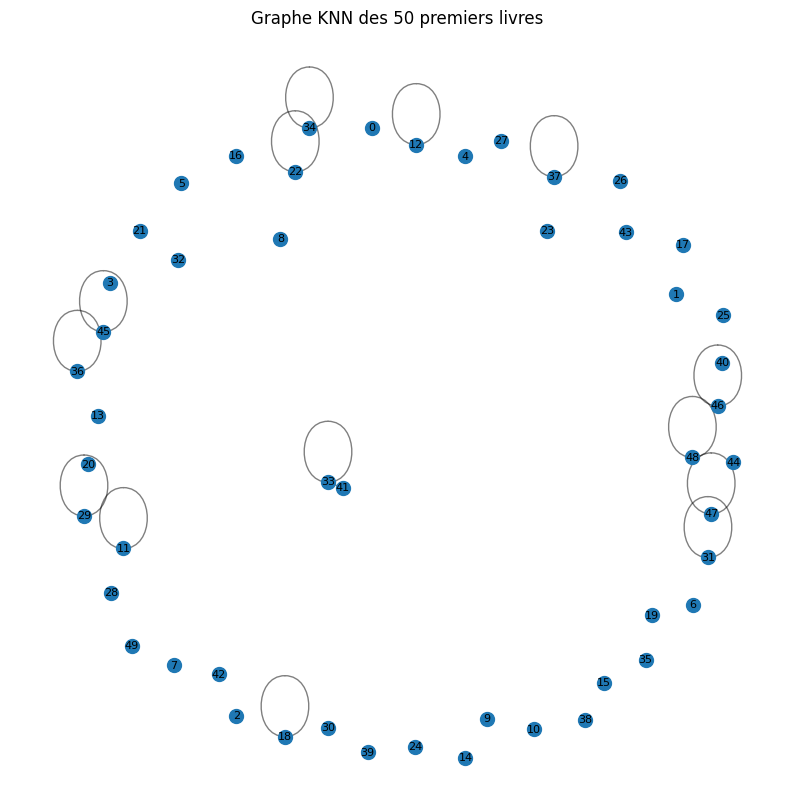

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

subset_indices = list(range(50))  # visualise juste 50 points

G = nx.Graph()

# Ajouter les noeuds
for idx in subset_indices:
    G.add_node(idx)

# Ajouter les arêtes vers les k voisins
for idx in subset_indices:
    distances, neighbors = knn.kneighbors([X[idx]])
    for neighbor in neighbors[0][1:]:  # on saute le premier (c'est lui-même)
        if neighbor in subset_indices:
            G.add_edge(idx, neighbor)

# Dessiner le graphe
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # positionnement des noeuds
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Graphe KNN des 50 premiers livres")
plt.axis('off')
plt.show()


## Ajout des genres en utilisant un autre dataset + propagation via KNN

## Ajout des genres et descriptions en utilisant un autre dataset

In [4]:
import requests

def get_book_genres(title):
    url = f"https://openlibrary.org/search.json?title={title}"
    response = requests.get(url)
    data = response.json()
    if data['docs']:
        book = data['docs'][0]
        genres = book.get('subject', [])
        return genres
    return []

# Exemple
genres = get_book_genres("Harry Potter")
print(genres)


[]


In [ ]:
import requests

API_URL = "https://api.hardcover.app/v1/graphql"
API_TOKEN = ""  # Remplace par ton token

def test_api_connection():
    query = """
    query {
      me {
        id
        username
      }
    }
    """
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }
    response = requests.post(API_URL, json={"query": query}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if "errors" in data:
            print("Erreur dans la requête GraphQL :", data["errors"])
        else:
            print("Connexion réussie ! Infos utilisateur :")
            print(data["data"]["me"])
    else:
        print(f"Erreur HTTP {response.status_code}: {response.text}")

test_api_connection()


Connexion réussie ! Infos utilisateur :
[{'id': 39049, 'username': 'redyydm'}]


In [ ]:
import requests
import json

API_URL = "https://api.hardcover.app/v1/graphql"
API_TOKEN = ""  # Remplace par ton token

def get_book_genres(slug):
    query = """
    query {
      search(
        query: "$title",
        query_type: "Book",
        per_page: 5,
        page: 1
      ) {
        book {
          title
        }
      }
    }
    """
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }
    variables = {"title":slug}

    response = requests.post(API_URL, json={"query": query}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        with open('fichier_export.json', 'w', encoding='utf-8') as f:
          json.dump(data, f, ensure_ascii=False, indent=4)
        docs=data['data']['search']['results']['hits']
        for doc in docs:
            print(doc['document']['genres'])

        
    else:
        print(f"Erreur API: {response.status_code} - {response.text}")
        return None, []
        
get_book_genres("les miserables")


KeyError: 'data'

In [ ]:
def search_book_slug(title):
    query = """
    query ($search: String!) {
      search(query: $search, first: 5) {
        edges {
          node {
            slug
            title
            author_names
          }
        }
      }
    }
    """
    variables = {"search": title}
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }

    response = requests.post(API_URL, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        results = data.get("data", {}).get("search", {}).get("edges", [])
        # Retourne le premier slug trouvé
        if results:
            return results[0]["node"]["slug"]
        else:
            print(f"Aucun résultat pour '{title}'")
            return None
    else:
        print(f"Erreur API: {response.status_code} - {response.text}")
        return None

## Ajout des genres et descriptions des livres via API google books (si possible)

In [4]:
import requests
import time

def get_book_info(isbn, api_key=None):
    base_url = 'https://www.googleapis.com/books/v1/volumes'
    params = {
        'q': f'isbn:{isbn}',
    }
    if api_key:
        params['key'] = api_key

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        return None

    data = response.json()
    items = data.get('items')
    if not items:
            return {
                 'title': None,
                'author': None,
                'categories': None,
                'description': None,
            }

    volume_info = items[0]['volumeInfo']
    return {
        'title': volume_info.get('title'),
        'author': volume_info.get('authors'),
        'categories': volume_info.get('categories'),
        'description': volume_info.get('description'),
    }

In [ ]:
books_df = pd.read_csv(path+'Books.csv')
books_df.rename(columns={'Book-Title':'title', 'Book-Author': 'author'}, inplace=True)
books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
enriched_data = []

for idx, row in books_df.head(10).iterrows():
    isbn = row['ISBN']
    info = get_book_info(isbn, '') 
    enriched_data.append(info)
    time.sleep(0.1) 

enriched_df = pd.DataFrame(enriched_data)

enriched_df

,0
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None
9,None


In [33]:
books_df

,ISBN,title,author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [34]:
books_df_enriched=books_df.merge(enriched_df, on='title')
books_df_enriched

,ISBN,title,author_x,Year-Of-Publication,Publisher,author_y,categories,description
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,"[Mark P. O. Morford, Robert J. Lenardon]",[Social Science],Provides an introduction to classical myths pl...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,[Richard Bruce Wright],[Actresses],"In a small town in Canada, Clara Callan reluct..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,[Carlo D'Este],[History],"Here, for the first time in paperback, is an o..."
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,[Amy Tan],[Fiction],An absorbing narrative of Winnie Louie's life.
4,0771074670,Nights Below Station Street,David Adams Richards,1988,Emblem Editions,[David Adams Richards],[Fiction],Another story based in the fictional rural tow...
...,...,...,...,...,...,...,...,...
203,0872203166,The Prince,Niccolo Machiavelli,1995,Hackett Publishing Company,[Niccolò Machiavelli],[Political ethics],"Notes, a 2-page map, an index, and an altogeth..."
204,0226500446,The Prince,Niccolo Machiavelli,1998,Press,[Niccolò Machiavelli],[Political ethics],"Notes, a 2-page map, an index, and an altogeth..."
205,0897110080,Black Beauty,Anna Sewell,1975,Worlds Great Classics,"[Anna Sewell, Ron Huron]",[Juvenile Fiction],A horse in nineteenth-century England recounts...
206,0895310619,Black Beauty,Anna Sewell,1981,Sharon Pubns,"[Anna Sewell, Ron Huron]",[Juvenile Fiction],A horse in nineteenth-century England recounts...


### API openlibrary

In [ ]:
import pandas as pd
import requests
import time

# Utiliser les 10 premiers ISBNs pour test
isbns = books['ISBN'].dropna().unique()

# Stocker les genres extraits
extracted_genres = []

for isbn in isbns:
    try:
        url = f"https://openlibrary.org/api/books?bibkeys=ISBN:{isbn}&jscmd=details&format=json"
        response = requests.get(url)
        data = response.json()

        key = f"ISBN:{isbn}"
        genres = data.get(key, {}).get('details', {}).get('subjects', [])
        
        # Extraire les noms des genres
        genres_list = [g['name'] if isinstance(g, dict) else g for g in genres]

        extracted_genres.append({
            'ISBN': isbn,
            'genres_from_api': ', '.join(genres_list)
        })

        # Pause pour éviter d’être bloqué par l’API
        time.sleep(1)

    except Exception as e:
        extracted_genres.append({'ISBN': isbn, 'genres_from_api': None})
        print(f"Erreur avec ISBN {isbn} : {e}")

# Convertir en DataFrame et enregistrer
genres_df = pd.DataFrame(extracted_genres)
genres_df.to_csv("genres_from_openlibrary.csv", index=False)

print("✅ Extraction terminée !")
